# Global Land Cover Data Layers

In [1]:
# Sentinel Hub
from sentinelhub import (
    SHConfig, DataCollection, Geometry, BBox, CRS,
    SentinelHubRequest, filter_times, bbox_to_dimensions, MimeType,
    SentinelHubBYOC, ByocCollection, ByocTile, ByocCollectionAdditionalData,
    DownloadFailedException
)

In [2]:
creodias_config = SHConfig()
creodias_config.sh_base_url = 'https://creodias.sentinel-hub.com'

In [3]:
byoc = DataCollection.define(
        name='Global Land Cover',
        api_id='byoc-f0a97620-0e88-4c1f-a1ac-bb388fabdf2c',  #Type
        catalog_id='f0a97620-0e88-4c1f-a1ac-bb388fabdf2c', # collection_id
        service_url='https://creodias.sentinel-hub.com', # End point
        is_timeless=False
    )
byoc

<DataCollection.Global Land Cover: DataCollectionDefinition(
  api_id: byoc-f0a97620-0e88-4c1f-a1ac-bb388fabdf2c
  catalog_id: f0a97620-0e88-4c1f-a1ac-bb388fabdf2c
  service_url: https://creodias.sentinel-hub.com
  is_timeless: False
  has_cloud_coverage: False
)>

In [4]:
from sentinelhub import bbox_to_dimensions

bbox = BBox([-3, 51.0, -1, 52], crs=CRS.WGS84)
aoi = bbox_to_dimensions( bbox, resolution=120)

evalscript_byoc = """
//VERSION=3
function setup() {
  return {
    input: [ "Bare_CoverFraction_layer",
             "BuiltUp_CoverFraction_layer",
             "Crops_CoverFraction_layer",
             "Grass_CoverFraction_layer",
             "MossLichen_CoverFraction_layer",
             "Shrub_CoverFraction_layer",
             "Tree_CoverFraction_layer",
             "PermanentWater_CoverFraction_layer",
             "SeasonalWater_CoverFraction_layer",
             "Change_Confidence_layer"
             ],
    output: { bands: 10 }
  };
}

function evaluatePixel(sample) {
  return [ sample.Bare_CoverFraction_layer,
           sample.BuiltUp_CoverFraction_layer,
           sample.Crops_CoverFraction_layer,
           sample.Grass_CoverFraction_layer,
           sample.MossLichen_CoverFraction_layer,
           sample.Shrub_CoverFraction_layer,
           sample.Tree_CoverFraction_layer,
           sample.PermanentWater_CoverFraction_layer,
           sample.SeasonalWater_CoverFraction_layer,
           sample.Change_Confidence_layer,           
           ];
}
"""

byoc_request = SentinelHubRequest(
    evalscript=evalscript_byoc,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=byoc,
            time_interval=('2016-01-01', '2020-12-01'),
        )],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF)
    ],
    bbox=bbox,
    size=aoi,
    config=creodias_config
)

byoc_data = byoc_request.get_data()
byoc_data

[array([[[  0,   0, 255, ...,   0,   0,   0],
         [  0,   0, 255, ...,   0,   0,   0],
         [  0,   0, 255, ...,   0,   0,   0],
         ...,
         [  0,   0, 255, ...,   0,   0,   0],
         [255,   0, 255, ...,   0,   0,   0],
         [  0,   0, 255, ...,   0,   0,   0]],
 
        [[  0,   0, 255, ...,   0,   0,   0],
         [  0,   0, 255, ...,   0,   0,   0],
         [  0,   0, 255, ...,   0,   0,   0],
         ...,
         [  0,   0, 255, ...,   0,   0,   0],
         [  0,   0, 255, ...,   0,   0,   0],
         [  0, 255, 255, ...,   0,   0,   0]],
 
        [[  0,   0, 255, ...,   0,   0,   0],
         [  0, 255, 255, ...,   0,   0,   0],
         [  0,   0, 255, ...,   0,   0,   0],
         ...,
         [  0,   0, 255, ...,   0,   0,   0],
         [255,   0, 255, ...,   0,   0,   0],
         [  0, 255, 255, ...,   0,   0,   0]],
 
        ...,
 
        [[  0, 255, 255, ...,   0,   0,   0],
         [  0,   0, 255, ...,   0,   0,   0],
         [  0,

In [5]:
len(byoc_data)

1

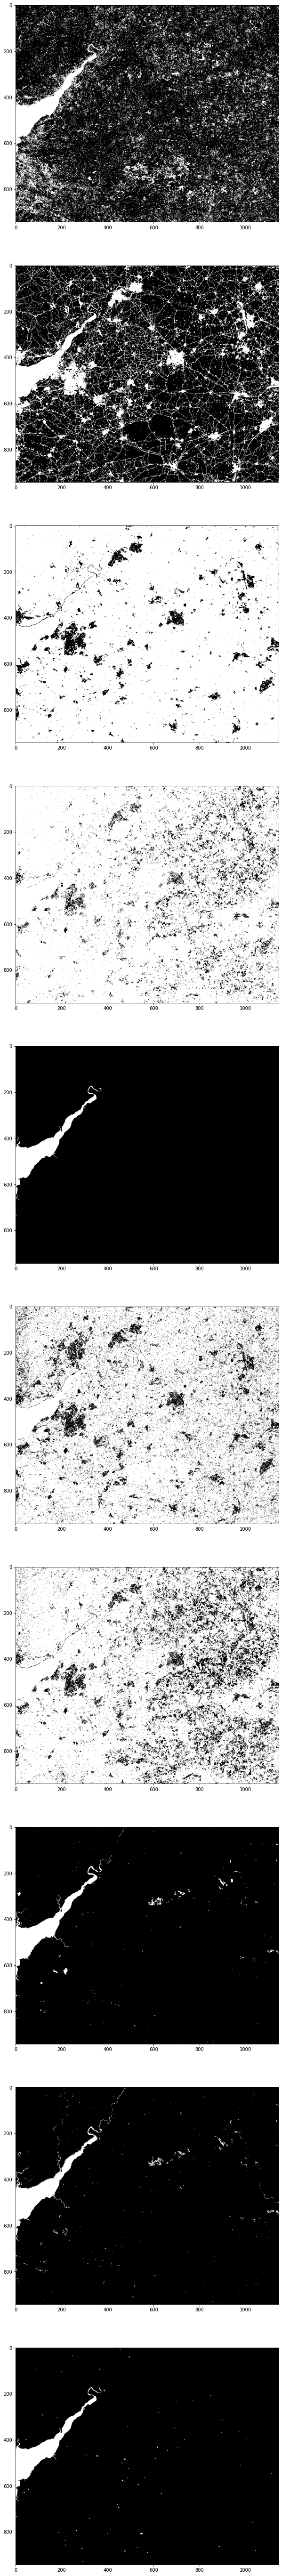

In [6]:
import matplotlib.pyplot as plt
import numpy as np

data = byoc_data[ 0 ]

f, axs = plt.subplots( 10, 1, figsize = (20,100))
for x in range ( 10 ):
    axs[ x ].imshow( data[ :, :, x ], cmap='gray' )

In [7]:
from datetime import datetime, timedelta
from sentinelhub import SentinelHubCatalog


# get catalog for collection
catalog = SentinelHubCatalog(
    base_url=byoc.service_url,
    config=creodias_config
)


timeframe = '2016-01-01T00:00:00Z', '2021-12-01T00:00:00Z'


# execute search
iterator = catalog.search (
            byoc,
            bbox=bbox,
            time=timeframe,
)

# filter timestamps into +- 1 hour groupings
timestamps = iterator.get_timestamps()
timestamps = filter_times( timestamps, timedelta(hours=1) )
timestamps

C:\Users\crwil\AppData\Roaming\Python\Python39\site-packages\sentinelhub\sh_utils.py:90: SHDeprecationWarning: Parameter base_url is deprecated and will soon be removed. Instead set config.sh_base_url = base_url and provide it with config parameter
  warnings.warn('Parameter base_url is deprecated and will soon be removed. Instead set '


[datetime.datetime(2016, 1, 1, 0, 0, tzinfo=tzutc()),
 datetime.datetime(2017, 1, 1, 0, 0, tzinfo=tzutc()),
 datetime.datetime(2018, 1, 1, 0, 0, tzinfo=tzutc()),
 datetime.datetime(2019, 1, 1, 0, 0, tzinfo=tzutc())]